Figure saved to: ../results/figures/bert_comparison.pdf


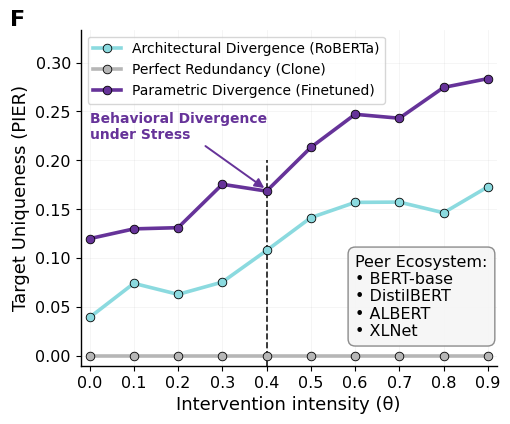

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---- load ----
DATA_PATH = "../results/tables/exp4_bert_disco_dosesplit.csv"
FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

df = pd.read_csv(DATA_PATH)

# ---- sanity: column names ----
required = {"Dose", "PIER", "Model"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}. Found: {list(df.columns)}")

# ---- palette (as you defined) ----
color_map = {
    "Parametric Divergence (Finetuned)": "#663399",
    "Architectural Divergence (RoBERTa)": "#8bdadf",
    "Perfect Redundancy (Clone)": "#b6b6b6",
}

# keep a stable plotting order (optional but recommended)
model_order = [
    "Architectural Divergence (RoBERTa)",
    "Perfect Redundancy (Clone)",
    "Parametric Divergence (Finetuned)",
]
models = [m for m in model_order if m in df["Model"].unique()]
# if unexpected names exist, append them deterministically
for m in sorted(set(df["Model"].unique()) - set(models)):
    models.append(m)

# ---- summary stats per (model, dose) ----
grp = df.groupby(["Model", "Dose"])["PIER"]
summary = grp.agg(
    mean="mean",
    q25=lambda x: np.quantile(x, 0.25),
    q75=lambda x: np.quantile(x, 0.75),
    std="std",
    n="count",
).reset_index()
summary["sem"] = summary["std"] / np.sqrt(summary["n"].clip(lower=1))

thetas = np.array(sorted(df["Dose"].unique()))

# ---- Styling (MATCH your heatmap panel) ----
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 13,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "axes.linewidth": 1.0,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---- figure (same size style as your reference) ----
fig, ax = plt.subplots(figsize=(5.2, 4.8))  # same size as your example

# subtle grid
ax.grid(True, which="major", linewidth=0.6, alpha=0.15)
ax.set_axisbelow(True)

# ---- plot each model: IQR ribbon + mean line + markers ----
for m in models:
    sub = summary[summary["Model"] == m].sort_values("Dose")
    x = sub["Dose"].values
    y = sub["mean"].values
    lo = sub["q25"].values
    hi = sub["q75"].values

    c = color_map.get(m, "#000000")

    # IQR ribbon
    ax.fill_between(x, lo, hi, alpha=0.18, linewidth=0, color=c, zorder=1)

    # line + markers
    ax.plot(
        x, y,
        linewidth=2.6,
        marker="o",
        markersize=6.2,
        color=c,
        markeredgecolor="black",
        markeredgewidth=0.6,
        label=m,
        zorder=3
    )

# ---- labels / axes ----
ax.set_xlabel("Intervention intensity (θ)")
ax.set_ylabel("Target Uniqueness (PIER)")
ax.set_xticks(thetas)
ax.set_xlim(thetas.min() - 0.02, thetas.max() + 0.02)

# give a little headroom (avoid top overlap)
ymin = min(-0.005, float(df["PIER"].min()) - 0.01)
ymax = float(df["PIER"].max()) + 0.05
ax.set_ylim(ymin, ymax)

# ---- legend (inside, clean) ----
# Place it similarly to your reference: inside upper area, but shifted right to avoid panel label
leg = ax.legend(
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0.01, 0.98),
    borderaxespad=0.0,
    handlelength=2.2
)

# Robust handle access across matplotlib versions
handles = getattr(leg, "legend_handles", None)
if handles is None:
    handles = getattr(leg, "legendHandles", None)
if handles is None:
    handles = leg.get_lines()

for h in handles:
    try:
        h.set_linewidth(3.0)
    except Exception:
        pass



# ---- annotations (kept but made less intrusive) ----
# Finetuned: point to mid-dose rise
if "Parametric Divergence (Finetuned)" in models:
    ax.annotate(
        "Behavioral Divergence\nunder Stress",
        xy=(0.4, 0.17),
        xytext=(0.0, 0.25),
        textcoords="data",
        arrowprops=dict(arrowstyle="-|>", lw=1.4, color="#663399", mutation_scale=14),
        fontweight="bold",
        fontsize=10.0, color="#663399",
        ha="left", va="top",
        zorder=5
    )

# # Clone: near zero line
# if "Perfect Redundancy (Clone)" in models:
#     ax.annotate(
#         r"Perfect Redundancy" "\n" r"(PIER $\approx$ 0)",
#         xy=(0.50, 0.0),
#         xytext=(0.30, ymin + 0.06),
#         textcoords="data",
#         arrowprops=dict(arrowstyle="-|>", lw=1.2, color="gray", mutation_scale=14),
#         fontsize=12.0, color="gray",
#         ha="center", va="bottom",
#         zorder=5
#     )
    
ax.vlines(
    x=0.4,
    ymin=ax.get_ylim()[0],
    ymax=0.20,
    colors="black",
    linestyles="--",
    linewidth=1.2,
    alpha=0.9,
    zorder=2
)


# ---- peer ecosystem box (bottom-right, smaller) ----
peer_text = "Peer Ecosystem:\n• BERT-base\n• DistilBERT\n• ALBERT\n• XLNet"
ax.text(
    0.66, 0.08, peer_text,
    transform=ax.transAxes,
    fontsize=11.5,
    va="bottom", ha="left",
    bbox=dict(boxstyle="round,pad=0.45", fc="#F5F5F5", ec="0.5", alpha=0.90)
)

ax.legend(fontsize=10)

# ---- panel label "F" (match your reference style) ----
ax.text(-0.17, 1.00, "F", transform=ax.transAxes,
        fontsize=16, fontweight="bold", va="bottom")

# manual layout: maximize subplot area (Nature-like)
fig.subplots_adjust(left=0.18, right=0.98, bottom=0.18, top=0.88, wspace=0.28)

# ---- save ----
save_path = os.path.join(FIG_PATH, "bert_comparison.pdf")
plt.savefig(save_path, bbox_inches=None)
print(f"Figure saved to: {save_path}")

plt.show()


Figure saved to: ../results/figures\fig5_bert_heatmap.pdf


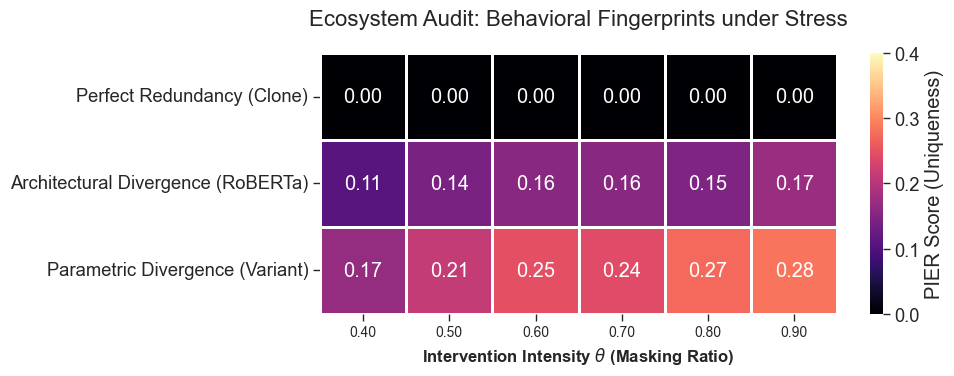

In [ ]:
# notebooks/04_bert_heatmap.ipynb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load Data
DATA_PATH = "../results/tables/exp4_bert_disco_dosesplit.csv"
FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH):
    print("Warning: Data file not found.")
else:
    df = pd.read_csv(DATA_PATH)

# --- Preprocessing for Heatmap ---
# We need a matrix: Rows = Models, Cols = Doses, Values = PIER
# Filter for Evaluation Phase only (Dose >= 0.4) to focus on the "Audit" part
heatmap_df = df[df['Dose'] >= 0.35].pivot(index="Model", columns="Dose", values="PIER")

# Sort rows to tell a story: Clone (Top) -> RoBERTa -> Finetuned (Bottom)
# Or sort by average PIER intensity
heatmap_df['mean'] = heatmap_df.mean(axis=1)
heatmap_df = heatmap_df.sort_values('mean').drop('mean', axis=1)

# Rename index for cleaner labels
name_map = {
    "DistilBERT (Redundant)": "Clone (Redundant)",
    "RoBERTa (Unique)": "RoBERTa (Unique)",
    "DistilBERT (Near-Redundant)": "Finetuned (Parametric)",
    "DistilBERT (Near‑Redundant)": "Finetuned (Parametric)"
}
heatmap_df.index = heatmap_df.index.map(lambda x: name_map.get(x, x))

# 2. Configure Aesthetics
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# 3. Plot Heatmap
plt.figure(figsize=(10, 4)) # Wide and short aspect ratio

# Draw Heatmap
# cmap="magma" gives a nice "Dark -> Bright" scientific feel
# vmin=0 ensure 0 is black/dark
ax = sns.heatmap(
    heatmap_df, 
    cmap="magma", 
    annot=True,       # Show values for precision
    fmt=".2f",        # 2 decimal places
    linewidths=1.0,   # Grid lines
    linecolor='white',
    cbar_kws={'label': 'PIER Score (Uniqueness)'},
    vmin=0.0,
    vmax=0.4          # Cap visual range to make differences pop
)

# 4. Customization
ax.set_title("Ecosystem Audit: Behavioral Fingerprints under Stress", fontsize=16, pad=20)
ax.set_xlabel(r"Intervention Intensity $\theta$ (Masking Ratio)", fontsize=12, fontweight='bold')
ax.set_ylabel("", fontsize=12)

# Rotate x-axis labels for readability, keep 2 decimal places
new_labels = [f"{col:.2f}" for col in heatmap_df.columns]
ax.set_xticklabels(new_labels, rotation=0, fontsize=10)
# plt.xticks(rotation=0)
# Ensure y-axis labels are horizontal
plt.yticks(rotation=0)

plt.tight_layout()

# Save
save_path = os.path.join(FIG_PATH, "fig5_bert_heatmap.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")

plt.show()